In [385]:
# load packages
import numpy as np 
#import scipy 
import pandas as pd
import os
import matplotlib.pyplot as plt #import matplotlib as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns #import mat73
import pickle as pkl
from datetime import datetime
import mne
from mne.viz import plot_topomap
from mne.io import RawArray
#import numpy.matlib
import scipy.stats as stats 
from scipy.stats import chi2, f
from scipy.stats import f as f_dist
from scipy.stats import f_oneway
from scipy.io import savemat
sns.set_theme() # set the plotting atmosphere
rbow = sns.color_palette('husl',8)

#### Set Basic Global Params

In [386]:
NumHarms = 4
NumBins = 6 # 6 contrasts
NumChans = 128
NumHemis = 2 # hemifield data = NumHarms*NumHemis # 8 : 2f1 4f1 6f1 8f1 2f2 4f2 6f2 8f2
NumFriters = NumHarms*NumHemis
chanInd = np.arange(1,NumChans,1) # channel index ..
cll = ['1%','3%','5%','16%','40%','100%'] # contrast levels 

#### Set Functions to get average complex values per subj per cond

In [387]:
def AvgComplexVals(NumSubs,NumBins,NumChans,RealImaginary,xfxiter,ppi):
    '''This function takes one key 2F1-8F2 AND
    only a PRE OR POST data
    RETURNS: [2X6X128] ARRAY 
    [0] = real / imaginary values
    [1] = 1% - 100% sweep (6) data
    [2] = all eeg channels
    '''
    pp_mat = np.zeros((NumSubs,NumBins,2,NumChans))
    # importing all pre data , real and imarinary numbers
    for si in range(NumSubs): # NumSubs
        # data in is PrePost x Contrast x real/imaginary x eeg channels
        xfx_d =  RealImaginary[si][xfxiter][ppi,:,:,:]
        #print(xfx_d.shape)
        pp_mat[si,:,:,:] = xfx_d
    complex_avgs = np.zeros((2,NumBins,NumChans))
    for i in range(2):
        complex_avgs[i] = np.nanmean(pp_mat[:,:,i,:],axis = 0) # [real imaginary x contrast x channel]
    return complex_avgs

### good function - might have to toss the above 
def GetComplexValsPerSubj(NumSubs,NumChans,RealImaginary,xfi,contrast_val):
    ''''
    This function iterates for:
    ONE XFX DATA KEY AND GETS ALL THE PRE POST COMPLEX VALUES FOR ALL 
    PARTICIPANTS FOR ONE CONTRAST FOR EACH CHANNEL.
    RETURNS 2 keys [PRE/POST]: each with 3D ARRAY : [NumSubs x Real/Imaginary x Channels]

    xfi = 0-8 any 2F1 - 8F2 data 
    contrast_val = Any value 0-5 [increasing contrast]
    '''
    prepost_complexs = {}

    for prepost in range(2):
        prepost_complexs[prepost] = {} # init pre == 0 and post  == 1 subkeys
        getcomplexs = np.zeros((NumSubs,2,NumChans)) # get each subjects complexs for each channel [2x128]
        for sIn in range(NumSubs):
            #complexIn = RealImaginary[sIn][xfxiter][prepost,contrast_val,:,:] # [real/imaginary vals / channels]
            getcomplexs[sIn,:]= RealImaginary[sIn][xfi][prepost,contrast_val,:,:]
        prepost_complexs[prepost] = getcomplexs

    return prepost_complexs

#### Init MNE + Topo Functions

In [388]:
# montage info 
montageIn = mne.channels.make_standard_montage("GSN-HydroCel-128")
info = mne.create_info(ch_names=montageIn.ch_names, sfreq=1000, ch_types="eeg")
info.set_montage(montageIn)
print(montageIn)

# function to plot topos
def init_TopoTemplate(title_In):
    """Prep topo plot fig and axes"""
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18,4), gridspec_kw=dict(height_ratios=[4]))
    #axes.axis('off')
    #axes[1].axis('off')
    #axes.gridspec_kw=dict(height_ratios=[3])
    #axes[1].gridspec_kw=dict(height_ratios=[3])
    #plt.tight_layout()
    plt.suptitle(f'{title_In}', fontsize = 20)
    return fig, axes

<DigMontage | 0 extras (headshape), 0 HPIs, 3 fiducials, 128 channels>


In [392]:
# def GetReal_Imaginary_Data(NumBins,NumChans,RealImaginary,sIn, harmonicInd):
#     # store all values per contrast
#     ComplexValuesPerBin = np.zeros((NumBins,2,2,NumChans)) # Contrast x Pre/Post x Real/Imaginary x 128 Channels

#     fIn = RealImaginary[sIn][harmonicInd]
#     condition_split = int((fIn.shape[3])/ 2)

#     for c in range(NumBins):
#         # pre post index
#         pre = fIn[c,:,:,:condition_split] # lowest contrast at 1%, 
#         post = fIn[c,:,:,condition_split:] 
#         pre_post_set = [pre,post] # group pre / post data for loop
#         complexVals = np.zeros((2,2,(NumChans))) # pre/post x real/imaginary x all channels
#         # average real and imaginary values per single channel for respective trials
#         for ppsi in range(len(pre_post_set)): # pre post set index
#             dsIn= pre_post_set[ppsi] # import pre or post 
#             for ch in range((NumChans)):
#                 realData = dsIn[0,ch,:] # index real values per 1 channel for all trials
#                 imagData = dsIn[1,ch,:] # index imaginary values per 1 channel for all trials
#                 r_avg = np.nanmean(realData) # returns 1 values per channel
#                 i_avg = np.nanmean(imagData) # returns 1 value per channel
#                 complexVals[ppsi,0,ch] = r_avg
#                 complexVals[ppsi,1,ch] = i_avg
                
#                 ComplexValuesPerBin[c,:,:,:] = complexVals
#     return ComplexValuesPerBin

In [393]:
# def ConcateAllDataperCo(NumSubs,AttnX_bool,GoodSubjArr,xFxData,xFX_Ind):
#     """Concates all subj data into a 4d array
#         DictIn = Dict of all data 
#         AttnX_bool and GoodSubjArr = binary bools to sort data
#         xFx_Ind = keys for all haronic and hemifield data
#         Returns::: Dict with 2 keys (attnL and attnR conditions given xFx)"""
#     AllData_perSubjCo = {}
#     co_temp1 = []
#     co_temp2 = []
#     for suIn in range(NumSubs):
#         if AttnX_bool[suIn] and GoodSubjArr[suIn] == 1:
#             co_temp1.append(xFxData[suIn][xFX_Ind])

#         if AttnX_bool[suIn] == 0 and GoodSubjArr[suIn] == 1:
#             co_temp2.append(xFxData[suIn][xFX_Ind])

#     AllData_perSubjCo[0] = np.array(co_temp1) # all attnL data
#     AllData_perSubjCo[1] = np.array(co_temp2) # all attnR data
#     return AllData_perSubjCo

#### Import processed data

In [397]:
# Main Directory of processed file from MatLab
MainDir = 'C:\\plimon\\LTP_analysis\\eegMatFiles\\AllMat' # set dir
os.chdir(MainDir) # change old dir, to this dir
dataFileNames = os.listdir(MainDir) # list files in dir
print(f'Total Files Avilable: {(dataFileNames)}')
##############################################
FileN = dataFileNames[6]# choose one                        
file_path1 = os.path.join(MainDir, FileN) # join paths and prep 2 load
print('Current WD:',file_path1) # does path exist ... ?
print('Does File #1 Exist?',os.path.exists(file_path1)) # yes or no

Total Files Avilable: ['AllSubj_MatFiles_C1_20240412_110418.pkl', 'AllSubj_MatFiles_C1_20240422_162530.pkl', 'AllSubj_MatFiles_C1_20240502_141234.pkl', 'AllSubj_MatFiles_ri_C1_20240502_143216.pkl', 'AllSubj_MatFiles_ri_C1_20240502_151155.pkl', 'CleanProcessed_Data_pnlApproved_20240528_143746.pkl', 'Clean_Procc_Data_pnlApproved_20240528_143903.pkl', 'ComplexVals_AllSubs_20240516_121757.pkl', 'ComplexVals_AllSubs_20240516_121917.mat', 'ComplexVals_AllSubs_20240516_122240.mat', 'ComplexVals_AllSubs_20240516_122723.pkl', 'EEG_Fully_ProcessedData_20240509_195111.pkl', 'ProcessedData_pnlApproved_20240514_190735.pkl', 'Processedf1_Data_pnlApproved_20240528_140901.pkl', 'Processedf2_Data_pnlApproved_20240528_141408.pkl']
Current WD: C:\plimon\LTP_analysis\eegMatFiles\AllMat\Clean_Procc_Data_pnlApproved_20240528_143903.pkl
Does File #1 Exist? True


## Extract Data from Imported pkl file

In [398]:
loadData = pkl.load(open(file_path1, 'rb'))
#print(loadData.keys())
xFxData = loadData['EEGData']
FileNames = loadData['SubIDs']
RealImaginary = loadData['RealImaginaryData_sIns']
NumSubs = int(len(RealImaginary.keys()))
print(f'Total Subjects : {NumSubs}')

str_catch = '-'
SubjID = np.array([file_name.split(str_catch)[1] for file_name in FileNames])
AttnX_Condition = np.array([file_name.split(str_catch)[2] for file_name in FileNames])
UniqueSubjs, SessionsComp = np.unique(SubjID, return_counts = True)
print(f'{int(len(UniqueSubjs))} Total Subjects')
print(f'{np.sum(SessionsComp == 2)} subjects completed both sessions')
print(SubjID) # subject ids 

Total Subjects : 56
33 Total Subjects
23 subjects completed both sessions
['2651' '2651' '2653' '2653' '2654' '2654' '2655' '2655' '2657' '2657'
 '2658' '2658' '2659' '2659' '2660' '2664' '2664' '2665' '2665' '2666'
 '2666' '2667' '2667' '2668' '2668' '2670' '2670' '2672' '2672' '2674'
 '2674' '2676' '2677' '2677' '2678' '2695' '2695' '2696' '2696' '2697'
 '2697' '2708' '2715' '2716' '2726' '2727' '2728' '2728' '2733' '2734'
 '345202' '345202' '345215' '345215' '345216' '345216']


In [403]:
#print(xFxData[50][0].shape)

(2, 6, 128)


In [401]:
AttnX_bool = np.zeros((NumSubs))
AttnX_bool = [1 if 'attnL' in x else 0 for x in AttnX_Condition]
AttnX_bool = np.array(AttnX_bool)
print(f'Total AttnL files: #{np.sum(AttnX_bool)}')
# GoodSubjArr = np.ones(NumSubs)
# BadSubs = ['2699']
# # BadSubs = ['2663','2734','2652']
# GoodSubs_bool = [1 if good_subj and x not in BadSubs else 0 for x, good_subj in zip(SubjID, GoodSubjArr)]
# print(np.unique(GoodSubs_bool, return_counts = True))
print(AttnX_bool[5:12])
print(AttnX_Condition[5:12])

Total AttnL files: #30
[0 1 0 1 0 1 0]
['attnR' 'attnL' 'attnR' 'attnL' 'attnR' 'attnL' 'attnR']


#### Get all averaged imaginary and real values across all good participants
#### avg_complex_vals[8][2]
#### 8 = 2f1 - 8f2
##### 2 = PRE OR POST DATA
#### [2x6x128] - 0 = real average number per channel, 1  = imag average number per ch

In [ ]:
# avg_complex_vals = {} # 
# for hemiharm in range(8):
#     avg_complex_vals[hemiharm] = {}
#     for pp in range(2):
#         avg_complex_vals[hemiharm][pp] = AvgComplexVals(RealImaginary,xfxiter = int(hemiharm),ppi = pp)

In [ ]:
# print(avg_complex_vals[0][0].shape)

# data = avg_complex_vals[0][0]
# fig,axs = plt.subplots(figsize = (10,3))


# print(data[0,0,:].shape)
# chlist = np.array(np.arange(0,NumChans,1))
# print(chlist.shape)
# for b in range(NumBins):
#     axs.scatter(np.arange(0,NumChans,1),data[0,b,:])
#     axs.vlines(SignificantChans, ymin = -1, ymax = 1, color = 'black')

In [ ]:
# pre_ri = avg_complex_vals[0][0]
# post_ri = avg_complex_vals[0][1]

# ppl = ['real','imaginary']

# fig,axs = plt.subplots(6,2,figsize = (12,18), sharey = True)
# for c in range(NumBins):
#     for pp in range(2):
#         axs[c,0].scatter(np.arange(0,NumChans,1),pre_ri[pp,c,:], color = rbow[pp], label = f'pre {ppl[pp]}')
#         #axs[c,0].plot(pre_ri[pp,c,:],color = rbow[pp])
#         axs[c,1].scatter(np.arange(0,NumChans,1),post_ri[pp,c,:], color = rbow[pp+3], label = f'post {ppl[pp]}')
#         #axs[c,1].plot(post_ri[pp,c,:],color = rbow[pp+3])

#         axs[c,0].legend(fontsize = 5)
#         axs[c,1].legend(fontsize = 5)

### modify function and capture real / imagainary data per eahc subject for each real / imagary / pre/post

In [ ]:
# def GetComplexValsPerSubj(RealImaginary,NumSubs,xfi,contrast_val):
#     ''''
#     This function iterates for:
#     ONE XFX DATA KEY AND GETS ALL THE PRE POST COMPLEX VALUES FOR ALL 
#     PARTICIPANTS FOR ONE CONTRAST FOR EACH CHANNEL.
#     RETURNS 2 keys [PRE/POST]: each with 3D ARRAY : [NumSubs x Real/Imaginary x Channels]

#     xfi = 0-8 any 2F1 - 8F2 data 
#     contrast_val = Any value 0-5 [increasing contrast]
#     '''
#     prepost_complexs = {}

#     for prepost in range(2):
#         prepost_complexs[prepost] = {} # init pre == 0 and post  == 1 subkeys
#         getcomplexs = np.zeros((NumSubs,2,NumChans)) # get each subjects complexs for each channel [2x128]
#         for sIn in range(NumSubs):
#             #complexIn = RealImaginary[sIn][xfxiter][prepost,contrast_val,:,:] # [real/imaginary vals / channels]
#             getcomplexs[sIn,:]= RealImaginary[sIn][xfi][prepost,contrast_val,:,:]
#         prepost_complexs[prepost] = getcomplexs

#     return prepost_complexs

In [ ]:
# DataOut = {}
# DataOut['RIVals'] = SubjectRealIMaginaryActivityPerChannel
# # DataOut['SubjNames'] = 
# # DataOut['GoodSubjBool'] = 
# # DataOut['AttnXiInd'] = 

# SaveDataDir = 'C:\\plimon\\LTP_analysis\\ComplexValues_Data'
# print(os.path.exists(SaveDataDir)) # does pth exist :p

# dnt = datetime.now() # add date and time bc im wreckless when saving ..
# fdnt = dnt.strftime("%Y%m%d_%H%M%S") # set the above as a string ...
# FileOutName = 'AllSubj_RealImagData_C1'
# FileN = f'{FileOutName}_{fdnt}.pkl' 
# NewFileNPath = os.path.join(SaveDataDir,FileN)
# print('Full New File Dir: ', NewFileNPath)

# saveFile = 'y'
# if saveFile == 'y':
#  with open(NewFileNPath, 'wb') as file:
#     pkl.dump(DataOut, file, protocol=pkl.HIGHEST_PROTOCOL)
#     print('MAT Data For All Subjs Saved! :))')
# else:
#     print('Did Not Save File! Change file name before switching to y!')
# print(os.path.exists(SaveDataDir)) # does pth exist :p


# save = 'no'

# if save == 'y':

#     SaveDataDir = 'C:\\plimon\\LTP_analysis\\ComplexValues_Data'
#     print(os.path.exists(SaveDataDir)) # does pth exist :p

#     CoStrings = ['2F1','4F1','6F1','8F1','2F2','4F2','6F2','8F2']

#     dnt = datetime.now() # add date and time bc im wreckless when saving ..
#     fdnt = dnt.strftime("%Y%m%d_%H%M%S") # set the above as a string ...

#     for i in range(8):
#         FileOutName = f'AllSubj_RealImagDataCo_{CoStrings[i]}'
#         dataExport = np.array(SubjectRealIMaginaryActivityPerChannel[i])
#         MatFileN = f'{FileOutName}_{fdnt}.mat' 
#         NewMatFileNPath = os.path.join(SaveDataDir,MatFileN)
#         print('Full New File Dir: ', NewFileNPath)
#         hdf5_file = h5py.File(NewMatFileNPath, 'w')
#         hdf5_file.create_dataset('data', data=dataExport)
#         hdf5_file.close()
#         print(f'Data saved as {NewMatFileNPath}')
# else:
#     print(f'No Data Saved, switch to Y')

### t2FC Function

In [ ]:
allComplexVals = {}

for acv in range(8):
    allComplexVals[acv] = {}

    SignificantChansperSweepInc = {}
    # this loop performs pre post F1 and F2 test per sweep increment 
    for iters in range(NumBins):
        sig_Chans = [] # store signifcant channels per contrast 
        # import 2F1 data for one contrast - computes real and imaginary data per post per key
        pp_test = GetComplexValsPerSubj(NumSubs,NumChans,RealImaginary,xfi = 0,contrast_val = iters)

        allComplexVals[acv] = pp_test

        ### convert pre and post values into a [N x real/imaginary x pre/post]
        for chan in range(NumChans):
            prebin1DataCh = np.array(pp_test[0][:,:,chan])
            postbin1DataCh = np.array(pp_test[1][:,:,chan])

            res,b = t2FC(prebin1DataCh, postbin1DataCh, testMu=[0, 0], alphaVal=0.01)
            #print(res)

            if b == 1:
                #print(f'{res}, Channels with significant diffs: {chan}')
                sig_Chans.append(chan)
                print(res)
                # fig,axs = plt.subplots(figsize = (3,3),sharey = True)
                # axs.scatter(prebin1DataCh,postbin1DataCh)
                # axs.set_title(f'chan # {chan}')
            SignificantChansperSweepInc[iters]  = sig_Chans


In [ ]:
print(allComplexVals.keys())
print(allComplexVals[0].keys())
print(allComplexVals[5][1].shape)
print(allComplexVals[0][0])

In [ ]:
DataOut = {}
DataOut['avgComplexVals'] = allComplexVals

SaveDataDir = 'C:\\plimon\\LTP_analysis\\eegMatFiles\\AllMat'
print(os.path.exists(SaveDataDir)) # does pth exist :p

dnt = datetime.now() # add date and time bc im wreckless when saving ..
fdnt = dnt.strftime("%Y%m%d_%H%M%S") # set the above as a string ...
FileOutName = 'ComplexVals_AllSubs'
FileN = f'{FileOutName}_{fdnt}.pkl' 
NewFileNPath = os.path.join(SaveDataDir,FileN)
print('Full New File Dir: ', NewFileNPath)

saveFile = 'y'
if saveFile == 'y':
 with open(NewFileNPath, 'wb') as file:
    pkl.dump(DataOut, file, protocol=pkl.HIGHEST_PROTOCOL)
    print('MAT Data For All Subjs Saved! :))')
else:
    print('Did Not Save File! Change file name before switching to y!')

In [ ]:
import os
from datetime import datetime
import scipy.io as sio

DataOut = {}
DataOut['avgComplexVals'] = allComplexVals

SaveDataDir = 'C:\\plimon\\LTP_analysis\\eegMatFiles\\AllMat'
print(os.path.exists(SaveDataDir))  # Check if the path exists

dnt = datetime.now()  # Add date and time
fdnt = dnt.strftime("%Y%m%d_%H%M%S")  # Format date and time as a string

FileOutName = 'ComplexVals_AllSubs'
FileN = f'{FileOutName}_{fdnt}.mat'  # Change the file extension to .mat
NewFileNPath = os.path.join(SaveDataDir, FileN)
print('Full New File Dir:', NewFileNPath)

saveFile = 'y'
if saveFile == 'y':
    sio.savemat(NewFileNPath, DataOut)  # Save data as .mat file
    print('MAT Data For All Subjs Saved! :))')
else:
    print('Did Not Save File! Change file name before switching to y!')


In [ ]:
print(SignificantChansperSweepInc.keys())

allSigChans = []
for i in range(6):
    print(f'Significant chans for Bin# {i+1} {SignificantChansperSweepInc[i]}')
    chiter = (len(SignificantChansperSweepInc[i]))
    #print(chiter)
    for sc in range(chiter):
        chIn = (SignificantChansperSweepInc[i][sc])
        allSigChans.append(chIn)
    #allSigChans.append(SignificantChansperSweepInc[i])

In [ ]:
# for sweepInd in range(NumBins):
#     fig,axes = init_TopoTemplate(f'2F1 - 2F2 PrePost Significant Chans At {cll[sweepInd]}')
#     IdentifiedSigChans = np.array(SignificantChansperSweepInc[sweepInd])
#     print(IdentifiedSigChans)
#     # chMask = np.zeros(NumChans, dtype = bool)
#     # chMask[IdentifiedSigChans] = False

#     empty_mat =np.array(np.ones((NumChans)))
#     #empty_mat[chMask == 1] = 1

#     im,_ = plot_topomap(empty_mat,info,axes = axes,show =False,cmap = 'Spectral_r', res = 20, contours =2,sphere=(0.0,0.0,0.0,0.09),outlines = 'head')

#     divider = make_axes_locatable(axes)
#     cax = divider.append_axes('right', size='4%', pad=0.5)
#     cbar = plt.colorbar(im, cax=cax)

In [ ]:
# allSigChans = np.array(allSigChans)
# SigChannels, reps = np.unique(allSigChans,return_counts = True)
# print(f'Channels with signficant pre post difference per hemifield: {SigChannels}')
# RepChans = SigChannels[reps >= 2] 
# print(f'Total Channels with identified significance {len(RepChans)}')
# fig,axes = init_TopoTemplate(f'Stable Select Channels')
# IdentifiedSigChans = np.array(SignificantChansperSweepInc[sweepInd])
# chMask = np.zeros(NumChans, dtype = bool)
# chMask[RepChans] = True
# empty_mat =np.array(np.ones((NumChans)))
# #empty_mat[chMask == 1] = 1
# im,_ = plot_topomap(empty_mat,info,mask = chMask,axes = axes,show =False,cmap = 'Spectral_r', res = 20)
# divider = make_axes_locatable(axes)
# cax = divider.append_axes('right', size='5%', pad=0.2)
# cbar = plt.colorbar(im, cax=cax)

# Start workbench

In [404]:
# empty matricies to fill with all subjects data
pre_2f1Data = np.zeros((NumSubs,NumBins,NumChans))
post_2f1Data = np.zeros_like((pre_2f1Data))

pre_2f2Data = np.zeros_like((pre_2f1Data))
post_2f2Data = np.zeros_like((pre_2f1Data))

for s in range(NumSubs):
    # import and segment 2f1 data in pre post matricies 
    pre_2f1Data[s,:,:] = xFxData[s][0][0,:,:]
    post_2f1Data[s,:,:] = xFxData[s][0][1,:,:]
    # import and segment 2f2 data in pre post matricies 
    pre_2f2Data[s,:,:] = xFxData[s][4][0,:,:]
    post_2f2Data[s,:,:] = xFxData[s][4][1,:,:]

In [ ]:
# preF1M = np.nanmean(pre_2f1Data,axis = 0) # [6 x 128] = [NumBins x NumChans]
# postF1M = np.nanmean(post_2f1Data,axis = 0)
# preF2M = np.nanmean(pre_2f2Data,axis = 0)
# postF2M = np.nanmean(post_2f2Data,axis = 0)


# preF1M = np.nanmean(pre_2f1Data[AttnX_bool == 1,:,:],axis = 0) # [6 x 128] = [NumBins x NumChans]
# postF1M = np.nanmean(post_2f1Data[AttnX_bool == 1,:,:],axis = 0)
# preF2M = np.nanmean(pre_2f2Data[AttnX_bool == 1,:,:],axis = 0)
# postF2M = np.nanmean(post_2f2Data[AttnX_bool == 1,:,:],axis = 0)


# preF1M = np.nanmean(pre_2f1Data[AttnX_bool == 0,:,:],axis = 0) # [6 x 128] = [NumBins x NumChans]
# postF1M = np.nanmean(post_2f1Data[AttnX_bool == 0,:,:],axis = 0)
# preF2M = np.nanmean(pre_2f2Data[AttnX_bool == 0,:,:],axis = 0)
# postF2M = np.nanmean(post_2f2Data[AttnX_bool == 0,:,:],axis = 0)


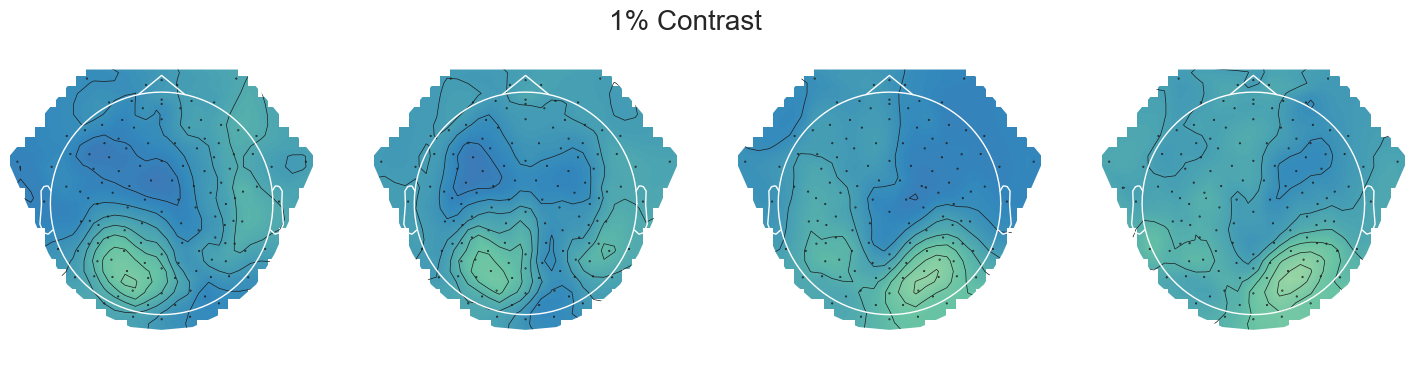

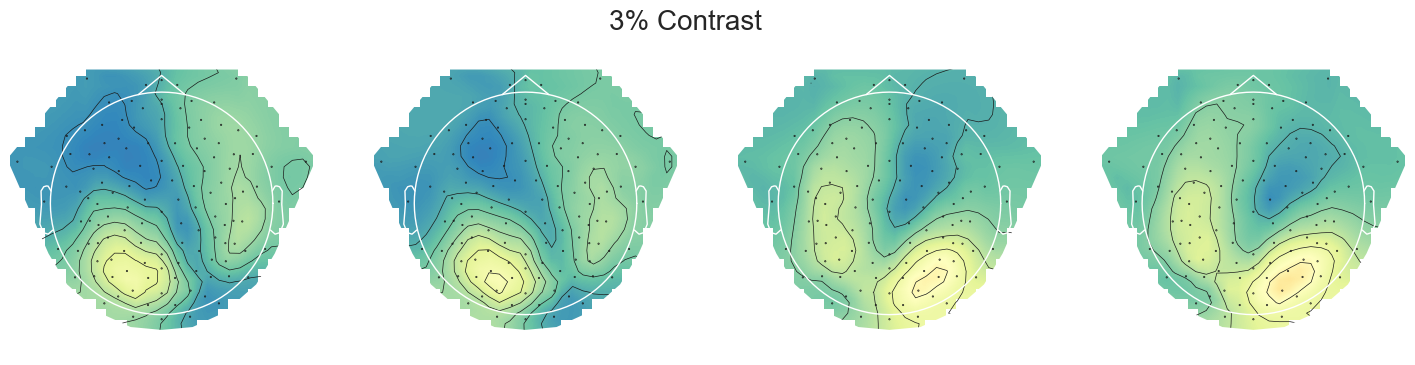

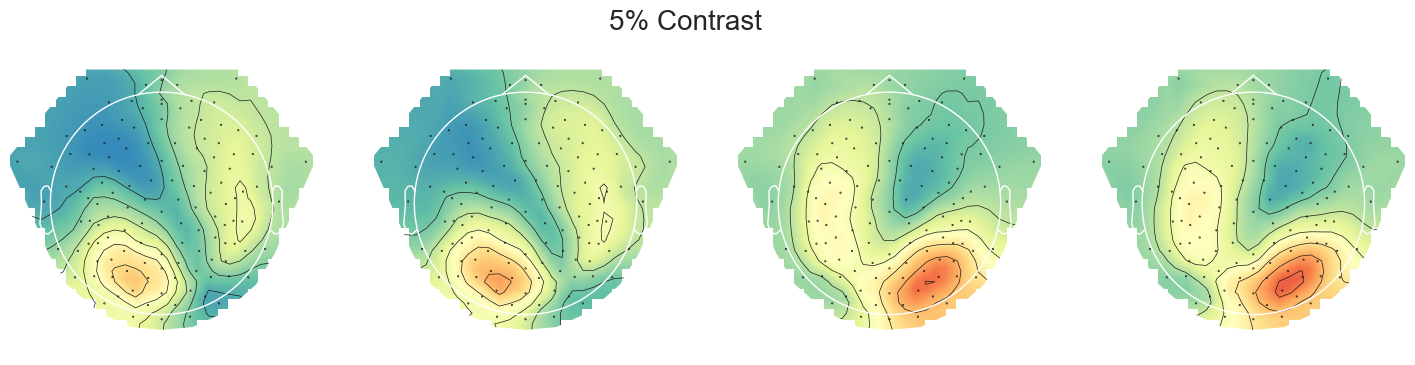

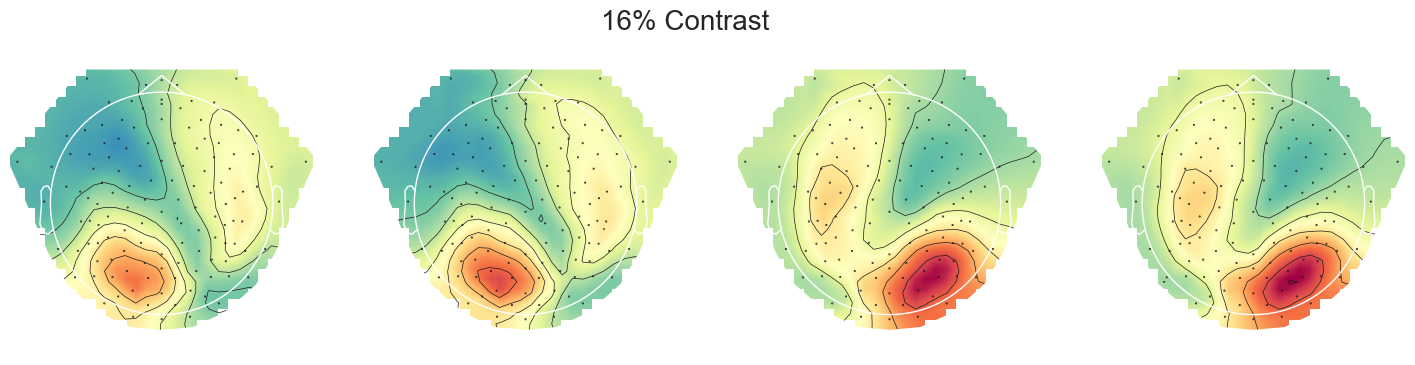

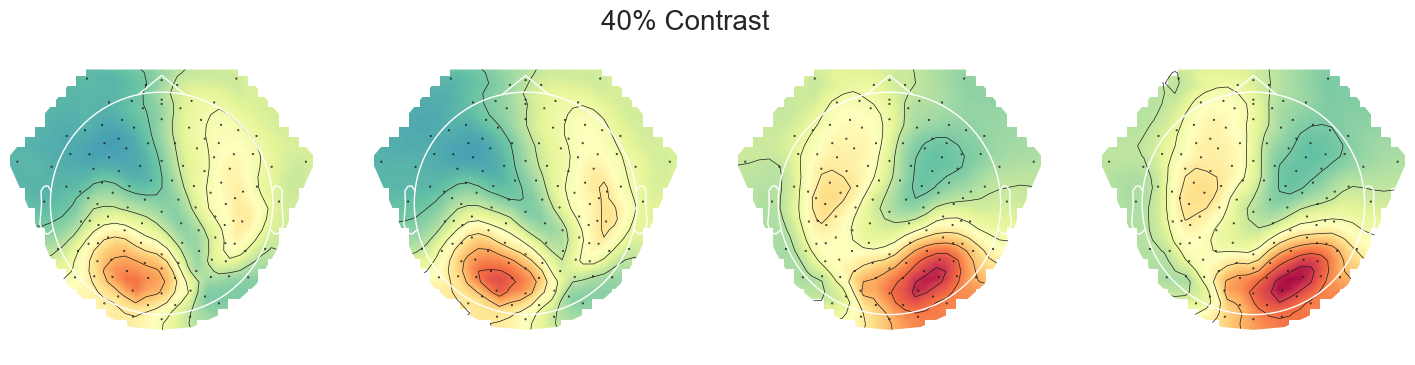

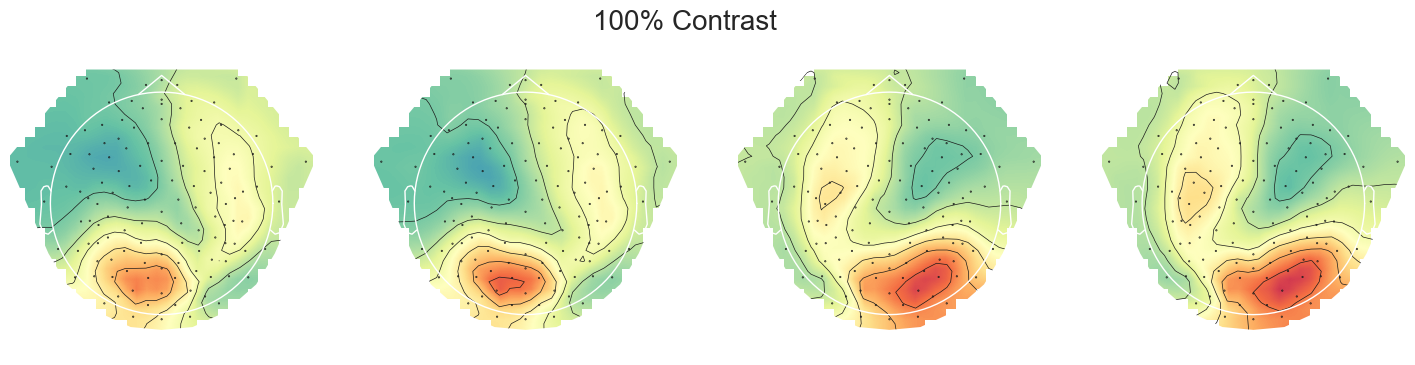

In [405]:
for b in range(NumBins):

    fig,axes = init_TopoTemplate(f'{cll[b]} Contrast')

    pos1 = preF1M[b,:]
    pos2 = postF1M[b,:]
    pos3 = preF2M[b,:]
    pos4 = postF2M[b,:]

    # findLims = np.concatenate((pos1,pos2,pos3,pos4))
    # print(findLims.shape)

    # minV = np.min(findLims)
    # maxV = np.max(findLims)

    # set = [minV,maxV]
    # print(set)

    setMin = 0
    setMax = 1.75
    set = [setMin,setMax]

    im,_ = plot_topomap(pos1,info,vlim = set,axes = axes[0],show =False,cmap = 'Spectral_r', res = 30,extrapolate = 'local', outlines = 'head',sphere=(0.0,0.0,0.0,0.09))
    # divider = make_axes_locatable(axes[0])
    # cax = divider.append_axes('right', size='5%', pad=0.2)
    # cbar = plt.colorbar(im, cax=cax)

    im,_ = plot_topomap(pos2,info,vlim = set,axes = axes[1],show =False,cmap = 'Spectral_r', res = 30,extrapolate = 'local', outlines = 'head',sphere=(0.0,0.0,0.0,0.09))
    # divider = make_axes_locatable(axes[1])
    # cax = divider.append_axes('right', size='5%', pad=0.2)
    # cbar = plt.colorbar(im, cax=cax)

    im,_ = plot_topomap(pos3,info,vlim = set,axes = axes[2],show =False,cmap = 'Spectral_r', res = 30,extrapolate = 'local', outlines = 'head',sphere=(0.0,0.0,0.0,0.09))
    # divider = make_axes_locatable(axes[2])
    # cax = divider.append_axes('right', size='5%', pad=0.2)
    # cbar = plt.colorbar(im, cax=cax)

    im,_ = plot_topomap(pos4,info,vlim = set,axes = axes[3],show =False,cmap = 'Spectral_r', res = 30,extrapolate = 'local', outlines = 'head',sphere=(0.0,0.0,0.0,0.09))
    # divider = make_axes_locatable(axes[3])
    # cax = divider.append_axes('right', size='5%', pad=0.2)
    # cbar = plt.colorbar(im, cax=cax)


In [ ]:
# function to plot topos
def init_TopoTemplate_DiffFigs(title_In):
    """Prep topo plot fig and axes"""
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4), gridspec_kw=dict(height_ratios=[4]))
    #axes.axis('off')
    #axes[1].axis('off')
    #axes.gridspec_kw=dict(height_ratios=[3])
    #axes[1].gridspec_kw=dict(height_ratios=[3])
    #plt.tight_layout()
    plt.suptitle(f'{title_In}', fontsize = 20)
    return fig, axes

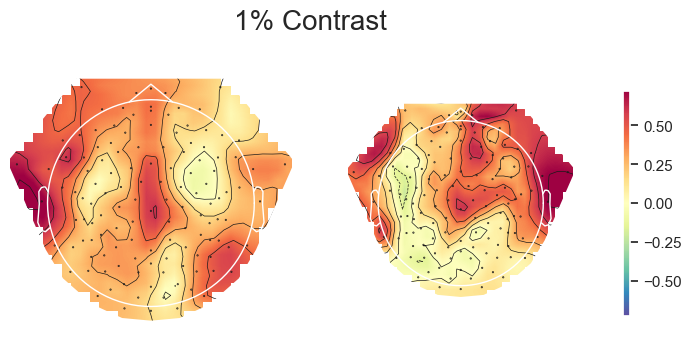

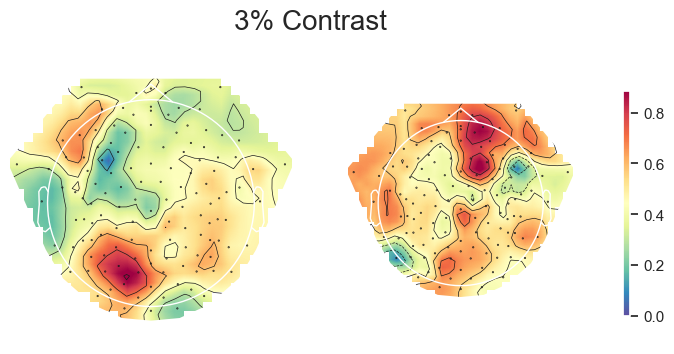

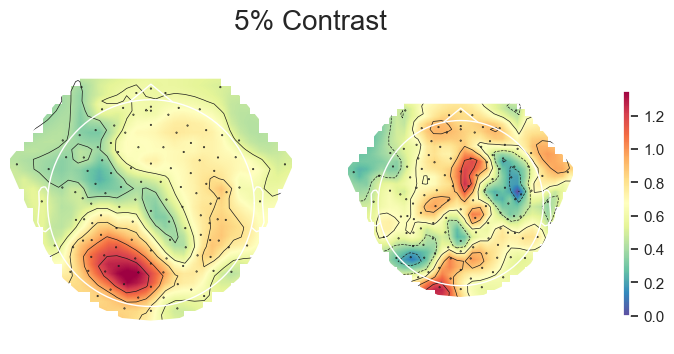

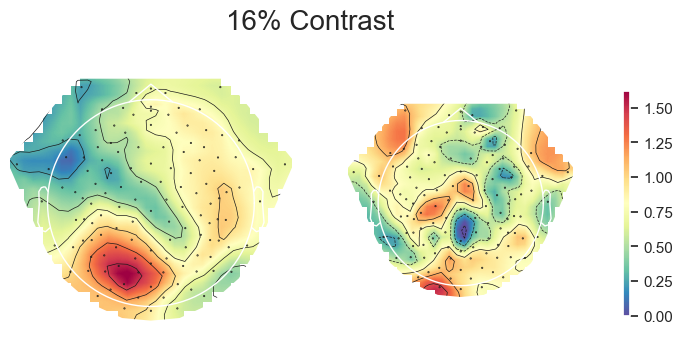

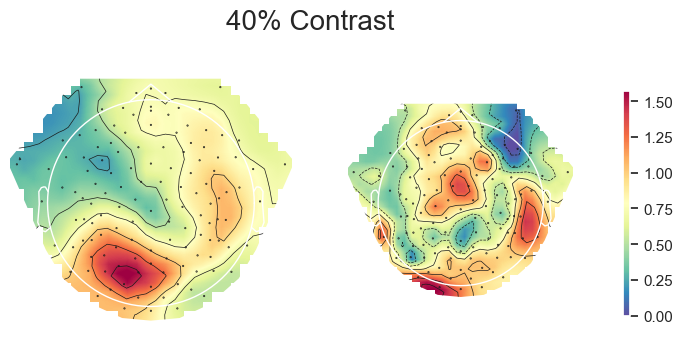

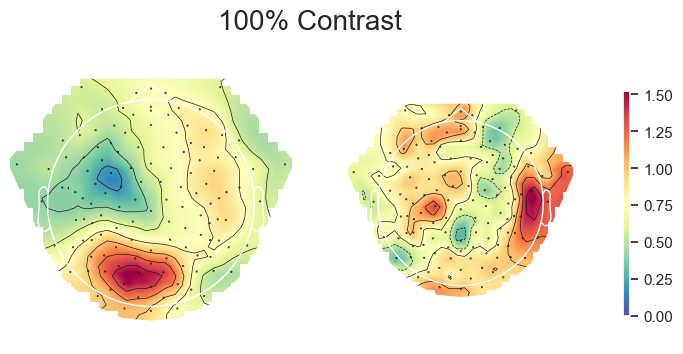

In [408]:
for b in range(NumBins): # NumBins

    fig,axes = init_TopoTemplate_DiffFigs(f'{cll[b]} Contrast')

    pos1 = preF1M[b,:]
    pos2 = postF1M[b,:]

    pos3 = preF2M[b,:]
    pos4 = postF2M[b,:]     


    # F1_Diff =pos2 - pos1 
    # F2_Diff = (pos4 - pos3) 

    # F1_Diff =((pos2 - pos1) / (pos1 + pos2))
    # F2_Diff = ((pos4 - pos3) /(pos3 + pos4))
    
    F1_Diff =((pos2 - pos1) / pos1 + pos2)
    F2_Diff = ((pos4 - pos3) /(pos3+ pos4))


    # limVer = np.concatenate((F1_Diff,F2_Diff),axis = 0)
    # maxLim = np.max(limVer)
    # minLim = np.min(limVer)

    # maxLim =0.1739
    # minLim =-0.1237
    # ampLims = [minLim,maxLim]

    #print(ampLims)
    im,_ = plot_topomap(F1_Diff,info,axes = axes[0],show =False,cmap = 'Spectral_r', res = 30,extrapolate = 'local', outlines = 'head',sphere=(0.0,0.0,0.0,0.09))
    divider = make_axes_locatable(axes[1])
    cax = divider.append_axes('right', size='3%', pad=0.5)
    cbar = plt.colorbar(im, cax=cax)

    im,_ = plot_topomap(F2_Diff,info,axes = axes[1],show =False,cmap = 'Spectral_r', res = 30,extrapolate = 'local', outlines = 'head',sphere=(0.0,0.0,0.0,0.09))
    # divider = make_axes_locatable(axes[1])
    # cax = divider.append_axes('right', size='5%', pad=0.2)
    # cbar = plt.colorbar(im, cax=cax)

# -0.0659278929479683, 0.08002854526783483]
    

In [ ]:
# test = GetComplexValsPerSubj(NumSubs,NumChans,RealImaginary,xfi = 0,contrast_val = 0)
# t = test[0]
# print(t.shape)

# x_ch = t[:,:,78]
# print(x_ch.shape)

# x_hy = np.hypot(x_ch[:,0],x_ch[:,1])
# print(x_hy.shape)

# plt.scatter(np.arange(0,NumSubs,1), x_ch[:,0], label = 'reals', color = 'black')
# plt.scatter(np.arange(0,NumSubs,1), x_ch[:,1], label = 'imaginaries', color = 'blue')

# plt.scatter(np.arange(0,NumSubs,1), x_hy, label = 'hypotenuse', color = 'red')

# plt.show()
# plt.scatter(x_ch[:,0], x_ch[:,1], label = 'reals', color = 'black')
# plt.hlines(0,xmin = -1,xmax = 1)
# plt.vlines(0,ymin = -1, ymax = 1)

In [ ]:
xFxData[0][0].shape # 2 6 128



# End of Workbench

### toy data to make for hypothesis plots :)

In [ ]:
data = xFxData[11][0]

#print(data.shape)


pres = data[0,:,:]
print(pres.shape)
posts = data[1,:,:]



crf_pre = np.nanmean(pres[:,40:95],axis = 1) # toy data to use 
crf_post = crf_pre + 0.5


fig,axs = plt.subplots(1,2,figsize = (9,4), sharey = True)
axs[0].plot(crf_pre, label = 'Pre Induction', color = 'black')
axs[0].plot(crf_post, label ='Post Induction', color = 'green')
axs[0].set_ylabel(f'Amplitude (mV)')
axs[0].set_xlabel(f' Contrast')
axs[0].hlines(0, xmin = 0, xmax = 5,color = 'black')
axs[0].legend()

axs[1].plot(crf_pre, label = 'Pre Induction', color = 'brown', linewidth = 5,alpha = 0.5)
axs[1].plot(crf_pre, label ='Post Induction', color = 'green',linewidth = 2,alpha = 0.5)
axs[1].set_ylabel(f'Amplitude (mV)')
axs[1].set_xlabel(f' Contrast')
axs[1].hlines(0, xmin = 0, xmax = 5,color = 'black')
axs[1].legend()